# **Apple Stock Market Prediction from Numerical and Textual Data**

# Imports

In [21]:
import pickle
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import (ModelCheckpoint,
                                         EarlyStopping,
                                         LearningRateMonitor,
                                         ProgressBar)

from pytorch_forecasting import GroupNormalizer, TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss, RMSE

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

warnings.filterwarnings("ignore")
pl.seed_everything(0)

Global seed set to 0


0

In [22]:
DATE_START, DATE_END = '2017-01-01', '2019-12-31'

# Data Preparation

## News Dataset

### PreProcessing

In [23]:
# Loading the DataFrame
news_df = pd.read_csv('csv/us_equities_news_dataset.csv')
news_df = news_df[['ticker', 'title', 'release_date']]

# Selecting Apple Data
news_df = news_df[news_df.ticker == 'AAPL'].drop('ticker', axis = 1)

# Converting Date column to datetime type
news_df['date'] = pd.to_datetime(news_df.release_date)

# Removing Missing Data Rows
news_df = news_df[news_df.notnull().all(axis = 1)]

# Subsetting the data between date ends
news_df = news_df[(DATE_START <= news_df.date) & (news_df.date <= DATE_END)]

### Sentimental Analysis

In [24]:
def get_sentiment(sentence):
    # Initializing Vad Sentiment Analyzer
    sid = SentimentIntensityAnalyzer()

    # Computing Sentiment Polarity Scores
    scores = sid.polarity_scores(sentence)
    return pd.Series(scores)

news_df = news_df.join(news_df.title.apply(get_sentiment))

# Taking The mean over Scores of the Same day
news_df = news_df.groupby(by = 'date').mean()
news_df.head()

,neg,neu,pos,compound
date,,,,
2017-01-01,0.121000,0.87900,0.00000,-0.07655
2017-01-02,0.000000,0.76550,0.23450,0.41900
2017-01-03,0.000000,0.75000,0.25000,0.25000
2017-01-04,0.000000,1.00000,0.00000,0.00000
2017-01-05,0.038625,0.88525,0.07625,0.07540


## Financial Data

### Loading Data from Yahoo Finance

In [15]:
fin_df = yf.download('AAPL', DATE_START, DATE_END)
fin_df = pd.DataFrame({'date': fin_df.index.values, 'close': fin_df.Close.values})
fin_df['date'] = pd.to_datetime(fin_df.date)
fin_df.head()

[*********************100%***********************]  1 of 1 completed


,date,close
0,2017-01-03,29.037500
1,2017-01-04,29.004999
2,2017-01-05,29.152500
3,2017-01-06,29.477501
4,2017-01-09,29.747499


### Plotting Target Variable

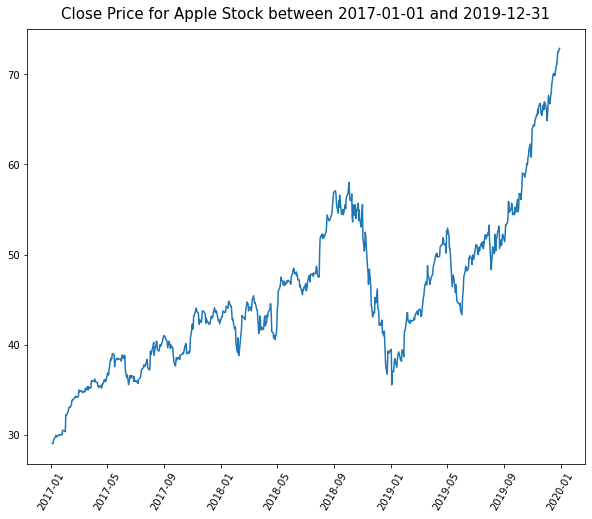

In [16]:
plt.figure(figsize = (10, 8))
plt.plot(fin_df.date, fin_df.close)
plt.title(f'Close Price for Apple Stock between {DATE_START} and {DATE_END}', fontdict = {'fontsize': 15}, pad = 10)
plt.xticks(rotation = 60)
plt.show()

## Concatenating Datasets

In [34]:
data = fin_df.join(news_df, on = 'date', sort = True)

# Adding time_idx and group columns (required by TimeSeriesDataset in pytorch-forecasting)
data['time_idx'] = data.index
data['group'] = 'group_0'

data.head()

,date,close,neg,neu,pos,compound,time_idx,group
0,2017-01-03,29.037500,0.000000,0.75000,0.25000,0.250000,0,group_0
1,2017-01-04,29.004999,0.000000,1.00000,0.00000,0.000000,1,group_0
2,2017-01-05,29.152500,0.038625,0.88525,0.07625,0.075400,2,group_0
3,2017-01-06,29.477501,0.000000,1.00000,0.00000,0.000000,3,group_0
4,2017-01-09,29.747499,0.102000,0.89800,0.00000,-0.098667,4,group_0


## Checking missing values

In [39]:
data[data.isna().any(axis = 1)]

,date,close,neg,neu,pos,compound,time_idx,group
27,2017-02-10,33.029999,NaN,NaN,NaN,NaN,27,group_0


In [40]:
# Rectifying missing row
data.loc[data.date == '2017-02-10', 'neg': 'compound'] = data.loc[data.date == '2017-02-09', 'neg': 'compound'].values

## Saving Processed Dataset

In [47]:
data.to_csv('csv/processed_data.csv', index = False)

## Creating Data Loaders

In [4]:
training_cutoff = '2018-12-31'

encoder_length = 2
prediction_length = 1

training = TimeSeriesDataSet(
    data[lambda x: x.date <= training_cutoff],
    time_idx = "time_idx",
    target = "close",
    group_ids = ["group"],
    min_encoder_length = encoder_length,
    max_encoder_length = encoder_length,
    min_prediction_length = prediction_length,
    max_prediction_length = prediction_length,
    static_categoricals = ["group"],
    static_reals = ["neg", "pos", "neu", "compound"],
    time_varying_known_reals = ["time_idx"],
    time_varying_unknown_reals = ["close"],
    target_normalizer = GroupNormalizer(
        groups = ["group"], transformation = "softplus", center = False
    )
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx = training.index.time.max() + 1, stop_randomization = True)

print(f'Training Data length: {len(training)}')
print(f'Validation Data length: {len(validation)}')

batch_size = 8
train_dataloader = training.to_dataloader(train = True, batch_size = batch_size, num_workers = 4)
val_dataloader = validation.to_dataloader(train = False, batch_size = batch_size, num_workers = 4)

Training Data length: 500
Validation Data length: 253


# HyperParameters Optimization

In [32]:
# tune
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path = "optuna_test",
    n_trials = 200,
    max_epochs = 50,
    gradient_clip_val_range = (0.01, 1.0),
    hidden_size_range = (8, 128),
    hidden_continuous_size_range = (8, 128),
    attention_head_size_range = (1, 4),
    learning_rate_range = (0.001, 0.1),
    dropout_range = (0.1, 0.3),
    trainer_kwargs = dict(gpus = 1),
    reduce_on_plateau_patience = 4,
    use_learning_rate_finder = False,
)
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

[I 2021-11-11 19:19:45,003] A new study created in memory with name: no-name-679dafcb-890d-4ef6-94ea-0cf4689613f4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 0
[I 2021-11-11 19:23:56,252] Trial 0 finished with value: 8.763789176940918 and parameters: {'gradient_clip_val': 0.21899761404136145, 'hidden_size': 128, 'dropout': 0.20927066943617118, 'hidden_continuous_size': 110, 'attention_head_size': 4, 'learning_rate': 0.0033881053953718474}. Best is trial 0 with value: 8.763789176940918.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 0
[I 2021-11-11 19:27:55,907] Trial 1 finished with value: 0.982075035572052 and parameters: {'gradient_clip_val': 0.025564383589729022, 'hidden_size': 69, 'dropout': 0.2950409891926566, 'hidden_continuous_size': 

In [5]:
with open("test_study.pkl", "rb") as fout:
    study = pickle.load(fout)
best_params = study.best_params
best_params

{'gradient_clip_val': 0.8196578496370998,
 'hidden_size': 116,
 'dropout': 0.16102979188227223,
 'hidden_continuous_size': 28,
 'attention_head_size': 4,
 'learning_rate': 0.0020736913888248906}

# Training

In [6]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate = best_params['learning_rate'],
    hidden_size = best_params['hidden_size'],
    attention_head_size = best_params['attention_head_size'],
    dropout = best_params['dropout'],
    hidden_continuous_size = best_params['hidden_continuous_size'],
    loss = QuantileLoss(),
    reduce_on_plateau_patience = 4,
)

In [35]:
pl.seed_everything(0)

class ProgBar(ProgressBar):
    def on_validation_end(self, trainer, pl_module):
        super().on_validation_end(trainer, pl_module)
        self.main_progress_bar.set_postfix(trainer.progress_bar_dict)
        self.val_progress_bar.close()
        print('\n')

chkpt_call = ModelCheckpoint(
    dirpath = 'ckpts',
    monitor = 'val_loss',
    filename = '{epoch}-{train_loss:.3f}-{val_loss:.3f}-{v_num}',
    mode = 'min'
)
lr_logger = LearningRateMonitor()
bar = ProgBar(refresh_rate = 1)

trainer = pl.Trainer(
    max_epochs = 50,
    gpus = 1,
    gradient_clip_val = best_params['gradient_clip_val'],
    # limit_train_batches = 30,
    # val_check_interval = 20,
    # limit_val_batches = 1,
    # fast_dev_run = True,
    # profiler = True,
    callbacks = [chkpt_call, lr_logger, bar],
)

trainer.fit(
    tft,
    train_dataloader = train_dataloader,
    val_dataloaders = val_dataloader,
)

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 336   
4  | static_variable_selection          | VariableSelectionNetwork        | 37.0 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 18.4 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 9.0 K 
7  | static_context_variable_selection  | GatedResidualNetwork            

Global seed set to 0




Epoch 0: 100%|██████████| 94/94 [00:05<00:00, 18.09it/s, loss=5.27, v_num=1, train_loss_step=3.380, val_loss=6.230]

Epoch 1: 100%|██████████| 94/94 [00:05<00:00, 17.92it/s, loss=1.3, v_num=1, train_loss_step=1.190, val_loss=1.980, train_loss_epoch=8.690]

Epoch 2: 100%|██████████| 94/94 [00:05<00:00, 17.20it/s, loss=0.924, v_num=1, train_loss_step=0.732, val_loss=1.800, train_loss_epoch=1.740]

Epoch 3: 100%|██████████| 94/94 [00:05<00:00, 18.19it/s, loss=0.82, v_num=1, train_loss_step=1.090, val_loss=1.860, train_loss_epoch=1.040]

Epoch 4: 100%|██████████| 94/94 [00:05<00:00, 18.33it/s, loss=0.772, v_num=1, train_loss_step=0.807, val_loss=1.820, train_loss_epoch=0.891]

Epoch 5: 100%|██████████| 94/94 [00:05<00:00, 17.74it/s, loss=0.71, v_num=1, train_loss_step=0.775, val_loss=1.700, train_loss_epoch=0.823]

Epoch 6: 100%|██████████| 94/94 [00:05<00:00, 17.79it/s, loss=0.71, v_num=1, train_loss_step=0.860, val_loss=1.560, train_loss_epoch=0.730]

Epoch 7: 100%|██████████| 94/94 [0

# Scoring on Data

In [9]:
train_dataloader = training.to_dataloader(train = False, batch_size = 1, num_workers = 4)
val_dataloader = validation.to_dataloader(train = False, batch_size = 1, num_workers = 4)

ckpt = chkpt_call.best_model_path
train_preds, train_index = tft.load_from_checkpoint(ckpt).predict(train_dataloader, return_index = True)
val_preds, val_index = tft.load_from_checkpoint(ckpt).predict(val_dataloader, return_index = True)

train_preds = train_preds.numpy().reshape(1, -1).squeeze(0)
val_preds = val_preds.numpy().reshape(1, -1).squeeze(0)

data = data[['time_idx', 'date', 'close']].set_index('time_idx')
train_data = train_index.join(data, on = 'time_idx')
val_data = val_index.join(data, on = 'time_idx')

train_true_vals = train_data['close'].values
val_true_vals = val_data['close'].values

In [10]:
print('Train MAE :', np.abs((train_true_vals - train_preds)).sum()/len(train_preds))
print('Train RMSE:', np.sqrt(((train_true_vals - train_preds)**2).sum()/len(train_preds)))
print('Validation MAE :', np.abs((val_true_vals - val_preds)).sum()/len(val_preds))
print('Validation RMSE:', np.sqrt(((val_true_vals - val_preds)**2).sum()/len(val_preds)))

Train MAE : 0.7614410983724617
Train RMSE: 1.0235492923981682
Validation MAE : 2.269913971424103
Validation RMSE: 3.330567331862992


## Plotting Scores

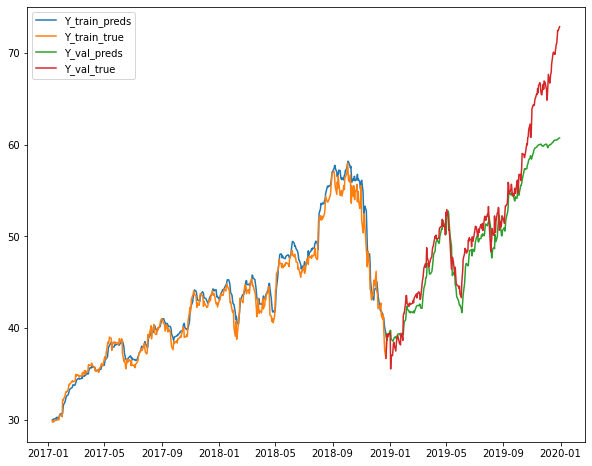

In [11]:
train_dates = train_data['date'].values
val_dates = val_data['date'].values

plt.figure(figsize = (10, 8))
plt.plot(train_dates, train_preds, label = 'Y_train_preds')
plt.plot(train_dates, train_true_vals, label = 'Y_train_true')
plt.plot(val_dates, val_preds, label = 'Y_val_preds')
plt.plot(val_dates, val_true_vals, label = 'Y_val_true')
plt.legend()
plt.show()